# **LOADING DATASET**



In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/diabetes.csv')  # Replace with the actual dataset path
data


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

# **Data Preprocessing**

In [ ]:
# Handle missing values if any
data.fillna(data.mean(), inplace=True)

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop('Outcome', axis=1))  # Assuming 'Outcome' is the target variable
X = scaled_data
y = data['Outcome']
X
y


0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

# **Exploratory Analysis**

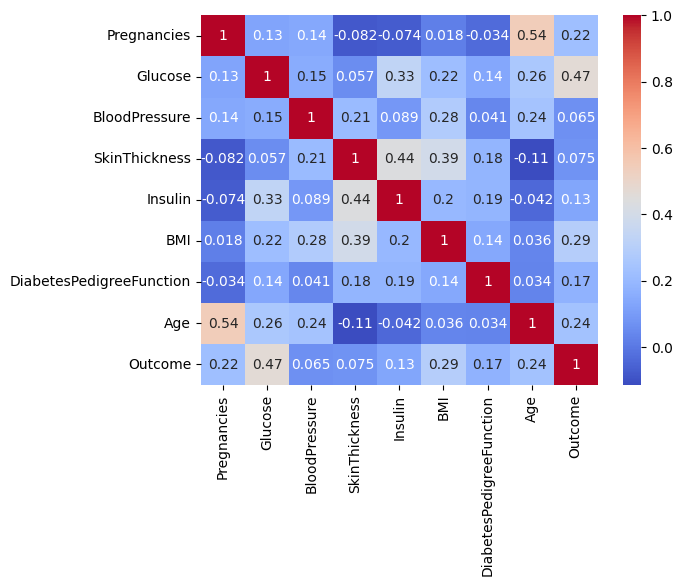

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize correlations
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()


# **Model Building**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and train the model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

# **Model Evaluation**

[[120  31]
 [ 30  50]] 

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231



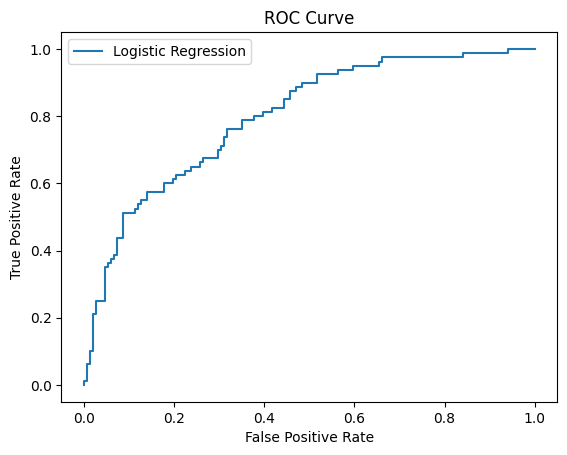

ROC-AUC Score: 0.7979304635761589


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

# Receiver Operating Characteristic Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print('ROC-AUC Score:', roc_auc_score(y_test, y_prob))


# **Hyper Parameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
import pickle

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
print('Best parameters:', grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
# print(classification_report(y_test, y_pred_best))
# Save the trained model to a .pkl file using pickle
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as logistic_regression_model.pkl")


Best parameters: {'C': 0.1, 'solver': 'saga'}
Model saved as logistic_regression_model.pkl


In [ ]:
# !pip install flask
# !pip install requests


ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 467, in run
    env = get_environment(lib_locations)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/__init__.py", line 85, in get_environment
    return select_backend().Environment.from_paths(paths)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/pkg_resources.py", line 232, in from_paths
    return cls(pkg_resources.WorkingSet(paths))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 613, in __init__
    self.add_entry(entry)
  File "/usr/local/lib/python3.1

**# Deployment**

In [ ]:
from flask import Flask, request, jsonify
import numpy as np
import pickle
import threading
from werkzeug.serving import make_server

# Load the trained model
with open('logistic_regression_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    input_features = np.array([data['features']])
    input_features_scaled = scaler.transform(input_features)  # Scale the input features
    prediction = model.predict(input_features_scaled)
    return jsonify({'prediction': int(prediction[0])})

class FlaskThread(threading.Thread):

    def __init__(self, app):
        threading.Thread.__init__(self)
        self.srv = make_server('0.0.0.0', 5009, app)
        self.ctx = app.app_context()
        self.ctx.push()

    def run(self):
        self.srv.serve_forever()

    def shutdown(self):
        self.srv.shutdown()

# Start the Flask server in a separate thread
flask_thread = FlaskThread(app)
flask_thread.start()


**TEST CASES**

In [ ]:
import requests
import json

url = 'http://127.0.0.1:5009/predict'
data1 = {'features': [6, 148, 72, 35, 0, 33.6, 0.627, 50]}  # Example input

response = requests.post(url, json=data1)
print(response.json())


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [18/May/2024 10:55:45] "POST /predict HTTP/1.1" 200 -


{'prediction': 1}


In [ ]:
import requests
import json

url = 'http://127.0.0.1:5009/predict'
data1 = {'features': [8, 183, 64, 0, 0, 23.3, 0.672, 32]}  # Example input

response = requests.post(url, json=data1)
print(response.json())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [18/May/2024 10:55:45] "POST /predict HTTP/1.1" 200 -


{'prediction': 1}


In [ ]:
import requests
import json

url = 'http://127.0.0.1:5009/predict'
data1 = {'features': [1, 89, 66, 23, 94, 28.1, 0.167,	21]}  # Example input

response = requests.post(url, json=data1)
print(response.json())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [18/May/2024 10:55:45] "POST /predict HTTP/1.1" 200 -


{'prediction': 0}


In [ ]:
import requests
import json

url = 'http://127.0.0.1:5009/predict'
data1 = {'features': [1, 85, 66, 29, 0, 26.6, 0.351,	31]}  # Example input

response = requests.post(url, json=data1)
print(response.json())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [18/May/2024 10:57:05] "POST /predict HTTP/1.1" 200 -


{'prediction': 0}
